# Train MNIST with only NumPy


In [ ]:
import numpy as np
import tensorflow as tf # only for data
import matplotlib.pyplot as plt

Before loading data, we will just make some quick utility functions

In [ ]:
def to_categorical(x, n_col=None):
  """ One hot encoding function"""
  if not n_col:
    n_col = np.amax(x) + 1

  one_hot = np.zeros((x.shape[0], n_col))
  one_hot[np.arange(x.shape[0]), x] = 1
  return one_hot

In [ ]:
def accuracy(y_true, y_pred):
  ### Returns accuracy ###
  return np.sum(y_true == y_pred, axis = 0) / len(y_true)

In [ ]:
def batch_loader(X, y = None, batch_size=64):
  """ Generates batches for training"""
  n_samples = X.shape[0]
  for i in np.arange(0, n_samples, batch_size):
    begin, end = i, min(i + batch_size, n_samples)
    if y is not None:
      yield X[begin:end], y[begin: end]
    else:
      yield X[begin:end]

## Data

We will load and process the data here

In [ ]:
## Now, lets load mnist
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
# This is the only time we use tensorflow

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
y_train, y_test = to_categorical(y_train.astype("int")), to_categorical(y_test.astype("int"))
X_train, X_test = X_train / 255.0, X_test / 255.0

In [ ]:
X_train, X_test = X_train.reshape(-1, 28*28), X_test.reshape(-1, 28*28)
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

In [ ]:
n_input_dim = 28*28 # 784
n_out = 10 # 10 classes

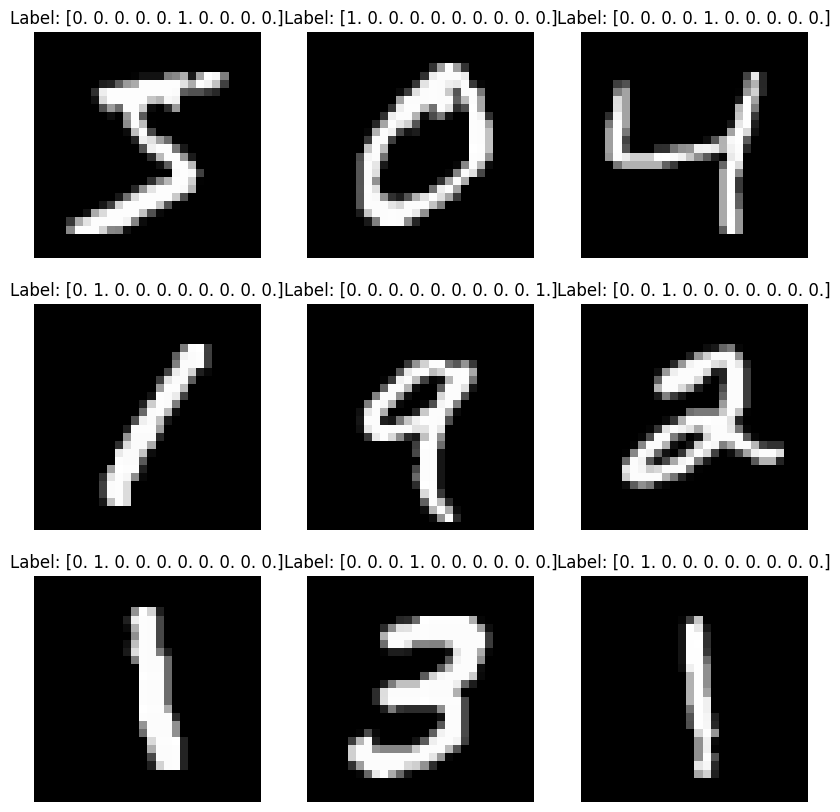

In [ ]:
#Visualize a few examples from the dataset

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.show()

## Loss and activation

We implement the loss and activation functions here

In [ ]:
# Now lets implement the loss and activation functions
class CrossEntropy():
  def __init__(self): pass

  def loss(self, y, p):
    p = np.clip(p, 1e-15, 1- 1e-15)
    return -y*np.log(p) - (1 - y) * np.log(1- p)

  def gradient(self, y, p):
    p = np.clip(p, 1e-15, 1- 1e-15)
    return -(y/p) + (1 - y) / (1 - p)

In [ ]:
# Now for our 2 activation functions, leakyReLU and Softmax

In [ ]:
class LeakyReLU():
  def __init__(self, alpha = 0.2):
    self.alpha = alpha

  def __call__(self, x):
    return self.activation(x)

  def activation(self, x):
    return np.where(x >= 0, x, self.alpha * x)

  def gradient(self, x):
    return np.where(x >= 0, 1, self.alpha)

In [ ]:
class Softmax():
  def __init__(self): pass

  def __call__(self, x):
    return self.activation(x)

  def activation(self, x):
    e_x = np.exp(x - np.max(x, axis = -1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims = True)

  def gradient(self, x):
    # Error was in our softmax
    p = self.activation(x)
    return p * (1 - p)

## Layers

We will implement the layers now

1. Activation Layer - its a wrapper for the activations
2. Linear Layer - these are the layers that form the basis for the neural network

In [ ]:
class Activation():
  def __init__(self, activation, name="activation"):
    self.activation = activation
    self.gradient = activation.gradient
    self.input = None
    self.output = None
    self.name = name

  def forward(self, x):
    self.input = x
    self.output = self.activation(x)
    return self.output

  def backward(self, output_error, lr = 0.01):
    return self.gradient(self.input) * output_error

  def __call__(self, x):
    return self.forward(x)

In [ ]:
class Linear():
  def __init__(self, n_in, n_out, name="linear"):
    limit = 1 / np.sqrt(n_in)
    self.W = np.random.uniform(-limit, limit, (n_in, n_out))
    self.b = np.zeros((1, n_out)) # Biases
    self.input = None
    self.output = None
    self.name = name

  def forward(self, x):
    self.input = x
    self.output = np.dot(self.input, self.W) + self.b # Wx + b
    return self.output

  def backward(self, output_error, lr = 0.01):
    input_error = np.dot(output_error, self.W.T)
    delta = np.dot(self.input.T, output_error) # Calculate the weights error

    # Usually, we would allow an optimizer function to update the weights
    # but here, we just use simple SGD
    self.W -= lr * delta
    self.b -= lr * np.mean(output_error)
    # We updated the weights below
    return input_error

  def __call__(self, x):
    return self.forward(x)

## Network

Let's create the network class

In [ ]:
class Network():
  def __init__(self, input_dim, output_dim, lr=0.01):
    # input_dim = 784, output_dim = 10 for mnist
    self.layers = [
                   Linear(input_dim, 256, name="input"),
                   Activation(LeakyReLU(), name="relu1"),
                   Linear(256, 128, name="input"),
                   Activation(LeakyReLU(), name="relu2"),
                   Linear(128, output_dim, name="output"),
                   Activation(Softmax(), name="softmax")
    ]
    self.lr = lr

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def backward(self, loss_grad):
    for layer in reversed(self.layers):
      loss_grad = layer.backward(loss_grad, self.lr)
    # Iterating backwards through the layers

  def __call__(self, x):
    return self.forward(x)

## Training

Our training loop is similar to a pytorch training loop

1. We do the forward pass
2. Calculate the loss/gradient
3. Send it backwards through the model

Note we dont have to anything like `optimizer.step()` or `optimizer.zero_grad()` like in pytorch, and that's because we didnt implement any optimizer like Adam, we just use SGD

In [ ]:
criterion = CrossEntropy()
model = Network(n_input_dim, n_out, lr=1e-3)

In [ ]:
EPOCHS = 5

In [ ]:
for epoch in range(EPOCHS):
  loss = []
  acc = []
  for x_batch, y_batch in batch_loader(X_train, y_train):
    out = model(x_batch) # Forward pass
    loss.append(np.mean(criterion.loss(y_batch, out))) # Loss - for display
    # We just passed the inputs incorrectly.
    acc.append(accuracy(np.argmax(y_batch, axis=1), np.argmax(out, axis=1))) # Accuracy - FOr display
    error = criterion.gradient(y_batch, out) # Calculate gradient of loss
    model.backward(error) # Backpropagation

  print(f"Epoch {epoch + 1}, Loss: {np.mean(loss)}, Acc: {np.mean(acc)}")

Epoch 1, Loss: 0.09211185166235768, Acc: 0.8522621268656716
Epoch 2, Loss: 0.04245934333840815, Acc: 0.9273887260127932
Epoch 3, Loss: 0.032155084024586486, Acc: 0.9463286247334755
Epoch 4, Loss: 0.02584794560451519, Acc: 0.9566897654584222
Epoch 5, Loss: 0.02153663037347205, Acc: 0.9645855543710021


In [ ]:
out = model(X_test) # Now we run the model on the test set
accuracy(np.argmax(y_test, axis=1), np.argmax(out, axis=1)) # We get an accuracy of 96%

0.9622

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Get the predicted labels for the test set
y_pred = np.argmax(out, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print the classification report
print(classification_report(y_true, y_pred))

# Print the confusion matrix
print(confusion_matrix(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.97      0.99      0.98      1135
           2       0.97      0.96      0.96      1032
           3       0.96      0.95      0.96      1010
           4       0.96      0.97      0.96       982
           5       0.93      0.97      0.95       892
           6       0.97      0.95      0.96       958
           7       0.98      0.94      0.96      1028
           8       0.97      0.95      0.96       974
           9       0.95      0.95      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 966    0    0    2    1    5    2    1    2    1]
 [   0 1126    2    1    0    1    2    1    2    0]
 [   7    7  986   10    6    1    5    3    7    0]
 [   1    1    4  964    1   20    0    7    7    5]
 [   1    0    3    0  953   

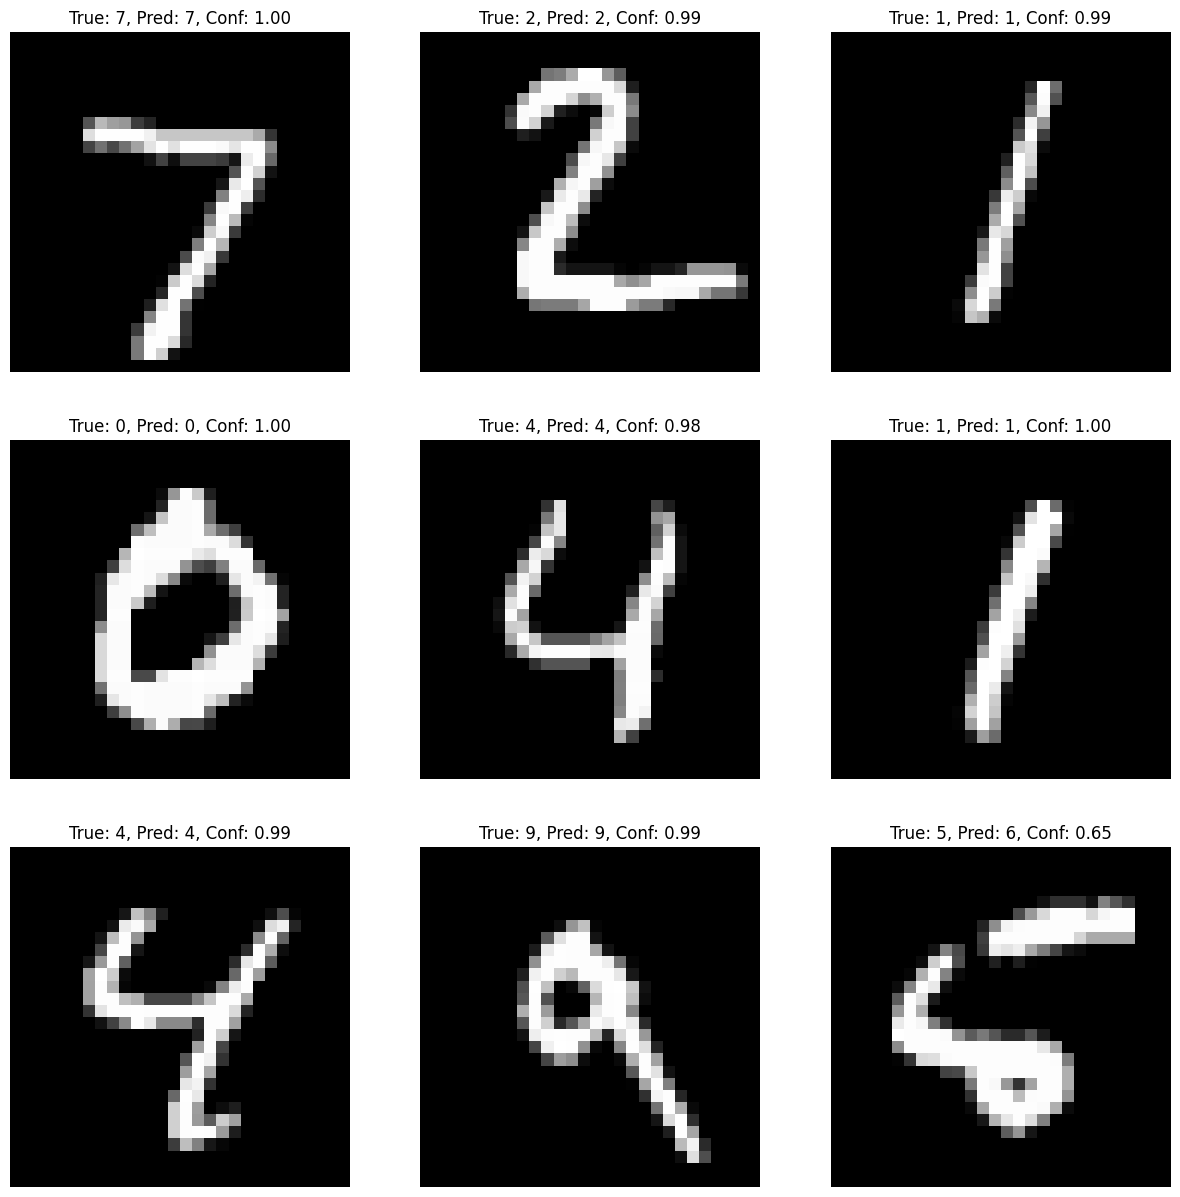

In [ ]:
# Get predictions and confidence scores for the test data
y_pred_probs = model(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)
confidence_scores = np.max(y_pred_probs, axis=1)

# Visualize some examples with confidence scores
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    plt.title(f"True: {y_true[i]}, Pred: {y_pred[i]}, Conf: {confidence_scores[i]:.2f}")
    plt.axis('off')
plt.show()


# MNIST with Tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Preprocess the data
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Build the model
model = Sequential()
model.add(Flatten(input_shape=(28, 28)))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8818 - loss: 0.4239 - val_accuracy: 0.9605 - val_loss: 0.1331
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9655 - loss: 0.1180 - val_accuracy: 0.9713 - val_loss: 0.0922
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9765 - loss: 0.0776 - val_accuracy: 0.9726 - val_loss: 0.0854
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.9819 - loss: 0.0580 - val_accuracy: 0.9746 - val_loss: 0.0819
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9872 - loss: 0.0426 - val_accuracy: 0.9768 - val_loss: 0.0757
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9735 - loss: 0.0865
Test accuracy: 0.9768000245094299


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Get the predicted labels for the test set
y_pred = np.argmax(out, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print the classification report
print(classification_report(y_true, y_pred))

# Print the confusion matrix
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.97      0.99      0.98      1135
           2       0.97      0.96      0.96      1032
           3       0.96      0.95      0.96      1010
           4       0.96      0.97      0.96       982
           5       0.93      0.97      0.95       892
           6       0.97      0.95      0.96       958
           7       0.98      0.94      0.96      1028
           8       0.97      0.95      0.96       974
           9       0.95      0.95      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 966    0    0    2    1    5    2    1    2    1]
 [   0 1126    2    1    0    1    2    1    2    0]
 [   7    7  986   10    6    1    5    3    7    0]
 [   1    1    4  964    1   20    0    7    7    5]
 [   1    0    3    0  953   

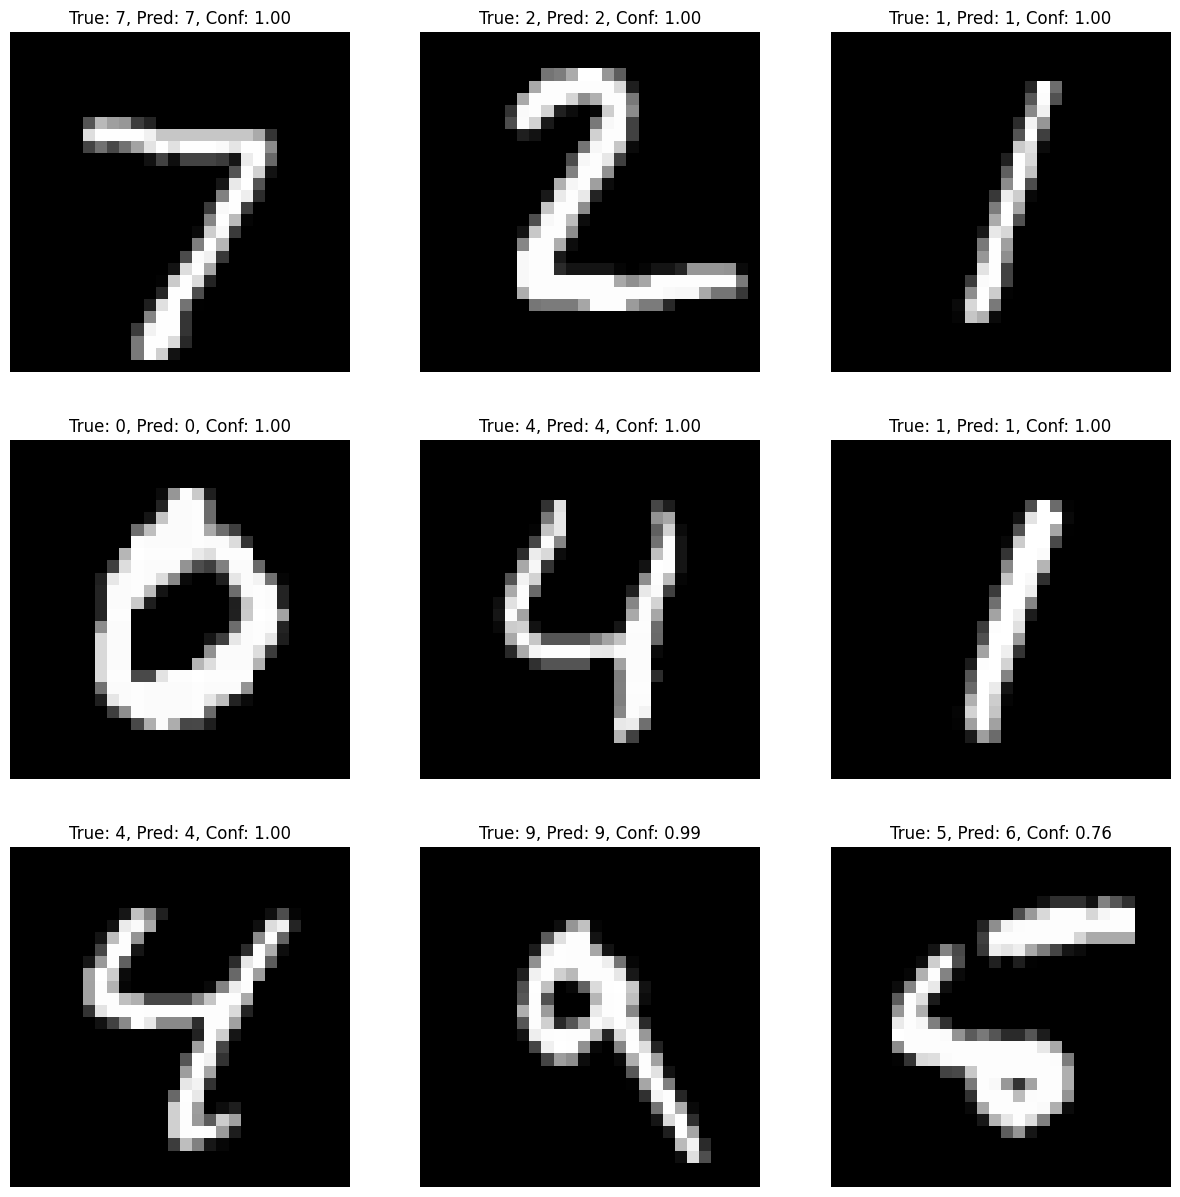

In [ ]:
# Get predictions and confidence scores for the test data
y_pred_probs = model(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)
confidence_scores = np.max(y_pred_probs, axis=1)

# Visualize some examples with confidence scores
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    plt.title(f"True: {y_true[i]}, Pred: {y_pred[i]}, Conf: {confidence_scores[i]:.2f}")
    plt.axis('off')
plt.show()